In [1]:
using Images
using Statistics
using Plots
using DSP
using StatsBase
using VectorizedStatistics
using ImageMorphology

In [2]:
function mask_site(file, threshold; n_sites=1)
    img = load(file)
    im_array = Float64.(img) * 65535 # concert to 16bit
    # Don't do frame averaging. Was found not neccessary for images used. 
    # Use stack standard dev projection to find polarity patch(es)
    img_std = std(im_array, dims=(3))[:,:,1]
    max_bin = 0
    bin = img_std .> maximum(img_std)*threshold
    bin = dilate(bin, r=1)
    bin_lab = label_components(bin)
    masks = zeros(size(im_array)[1], size(im_array)[2], size(im_array)[3], n_sites)
    for i in range(1,n_sites)
        bin = bin .- max_bin         
        max_loc = findmax(bin.*img_std)[2]          # mask the image. find the max. get the coords.
        max_lab = bin_lab[max_loc]                  # get label in labeled mask from coords
        max_bin = bin_lab .== max_lab               # Make binary mask only around correct component
        im_masked = im_array .* max_bin 
        masks[:,:,:,i] = im_masked
    end
    return masks
end

mask_site (generic function with 1 method)

In [3]:
# Modified for mutli-signal to return times instead of time-crops
function crop_times(signal, frames, thresh)
    signal=signal.-minimum(signal)
    start = Integer(findall(signal .> ((maximum(signal))*thresh))[1])
    if start + frames < length(signal)
        times = start:start+Integer(frames)
        return times
    else 
        last = length(signal)
        times = last-Integer(frames):last
        print(".")
        return times
    end
end

crop_times (generic function with 1 method)

In [52]:
file = "../data/double_probe/cell6-g.tif"
img = load(file)
g = Float64.(img) * 65535
file = "../data/double_probe/cell6-r.tif"
img = load(file)
r = Float64.(img) * 65535;

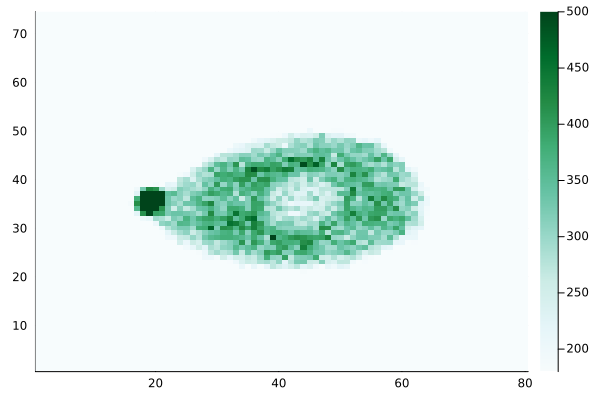

In [94]:
heatmap(g[:,:,end], cmap=:BuGn, clim=(180,500))

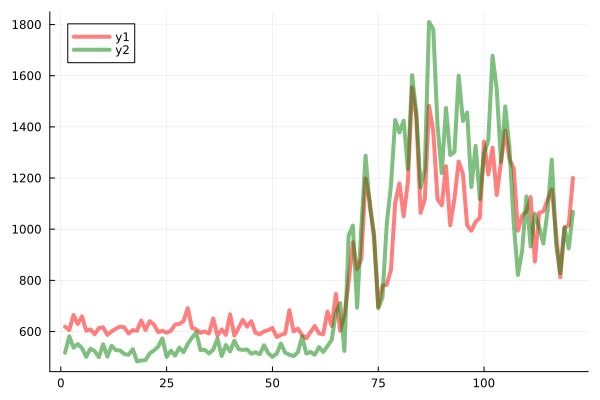

In [44]:
signal_r = maximum(r, dims=(1,2))[1,1,:]
signal_g = maximum(g, dims=(1,2))[1,1,:]
plot(signal_r * (mean(signal_g) / mean(signal_r)), color="red", linewidth=4, alpha=0.5)
plot!(signal_g, color="green", linewidth=4, alpha=0.5)

..

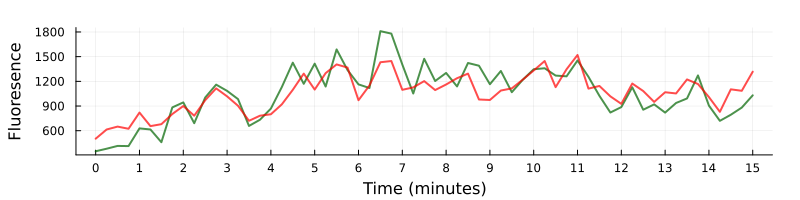

In [62]:
file_g = "../data/double_probe/cell6-g.tif"
file_r = "../data/double_probe/cell6-r.tif"

interval = 15
time_threshold=0.5
m1 = mask_site(file_g, 0.3, n_sites=1);
m2 = mask_site(file_r, 0.3, n_sites=1);
im_size = length(m1[:,1,1])*length(m1[1,:,1])
q1 = vquantile(m1, (im_size-1)/im_size, dims=(1,2))[1,1,:]
q2 = vquantile(m2, (im_size-1)/im_size, dims=(1,2))[1,1,:]
times_max1 = crop_times(q1, 15*(60/interval), time_threshold)
times_max2 = crop_times(q2, 15*(60/interval), time_threshold)
crop1 = q1[max(times_max1, times_max2)]
crop2 = q2[max(times_max1, times_max2)]
t = range(0,60/15*15)*(15/60) # Convert from 1 frame every 5 sec, to minutes
plot(t, crop1, xticks=range(0,15), linewidth=2, label=false, 
    xlabel="Time (minutes)", ylabel="Fluoresence", size=(800,200), margin=5Plots.mm, color="darkgreen", alpha=0.7)
plot!(t, crop2 * (mean(crop1)/ mean(crop2)), xticks=range(0,15), linewidth=2, label=false, color="red", alpha=0.7)

In [8]:
n = 5
file_g = "../data/double_probe/cell$n-g.tif"
file_r = "../data/double_probe/cell$n-r.tif"
cell = "cell$n"

interval = 15
time_threshold=0.5
m1 = mask_site(file_g, 0.5, n_sites=1);
m2 = mask_site(file_r, 0.5, n_sites=1);
im_size = length(m1[:,1,1])*length(m1[1,:,1])
q1 = vquantile(m1, (im_size-1)/im_size, dims=(1,2))[1,1,:]
q2 = vquantile(m2, (im_size-1)/im_size, dims=(1,2))[1,1,:]
times_max1 = crop_times(q1, 15*(60/interval), time_threshold)
times_max2 = crop_times(q2, 15*(60/interval), time_threshold)
crop1 = q1[max(times_max1, times_max2)]
crop2 = q2[max(times_max1, times_max2)]
t = range(0,60/15*15)*(15/60) # Convert from 1 frame every 15 sec, to minutes
plot(t, crop1, linewidth=2, label=false, 
    size=(600,150), color="darkgreen", alpha=0.7)
plot!(t, crop2 * (mean(crop1)/ mean(crop2)), linewidth=2, label=false, color="red", alpha=0.7,
    dpi=600, grid=false, xticks=(0:15), yticks=false)
savefig("../figures/naked_traces/double_trace_cell$(n)_special")

"/home/dinosaur/Lab/Polarity/proj/fig6-deletions/figures/naked_traces/double_trace_cell5_special.png"

In [ ]:
mask = mask_site("$dir$f")
max_patch = maximum(mask, dims=(1,2))[1,1,:]
crop_max = crop_time(max_patch, 15*(60/5), 0.5)
t = range(1,length(crop_max))*(5/60)

cell = replace(f,".tif" => "")

n+=1

plot(size=(400,100))
plot!(t, crop_max, linewidth=2, label=false, dpi=600, grid=false, xticks=false, yticks=false, framestyle = :box)
    savefig("../figures/naked_traces/$cell.png")